# Compute Magnitudes from BK models SED in Auxtel filters (SDSS prime)

- author Sylvie Dagoret-Campagne
- creation date : 2024/07/31
- update : 2024/07/31 : 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [4]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [5]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


In [6]:
WL = emul.GetWL()

#### Library to fit atmosphere

In [7]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

#### Library that encapsulate calculations for Photometric correction

In [8]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [9]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [10]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

#### library rubin_sim defining LSST parameters, namely for photometric calculations

In [11]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

## Configuration

In [12]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [13]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

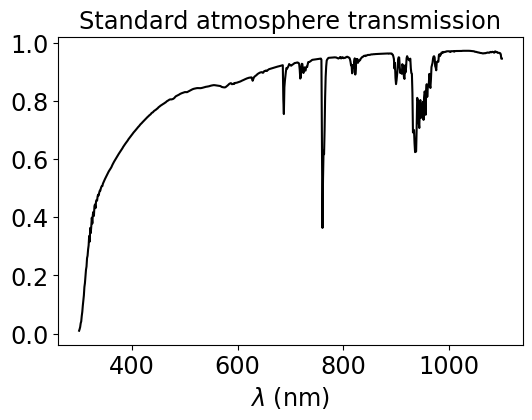

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

### Check LSST instrument throughput

Photometric Correction package should find the instrumental passband of LSST

Text(0.5, 1.0, 'Instrument throughput (auxtel)')

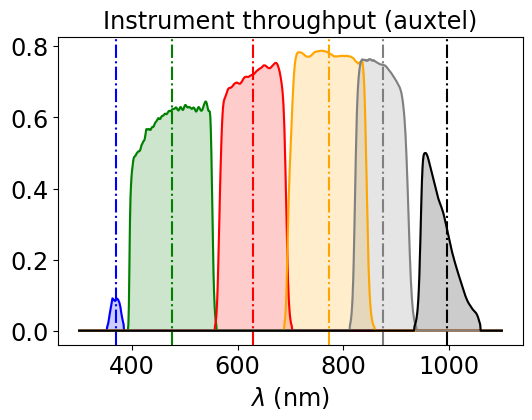

In [15]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_inst[f].wavelen,pc.bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput (auxtel)")

### Check LSST standard Filter throughputs

Text(0.5, 1.0, 'Total filter throughput (auxtel)')

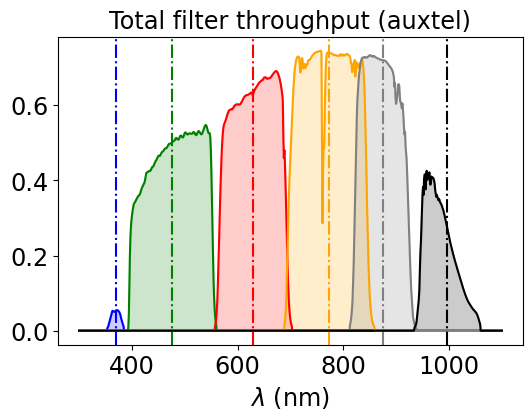

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    axs.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total filter throughput (auxtel)")

## Variation of PWV

In [17]:
am = 1.2
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,10,0.5)
NPWV = len(all_pwv)

In [18]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

### PWV variation :  Observed filter and normalized response

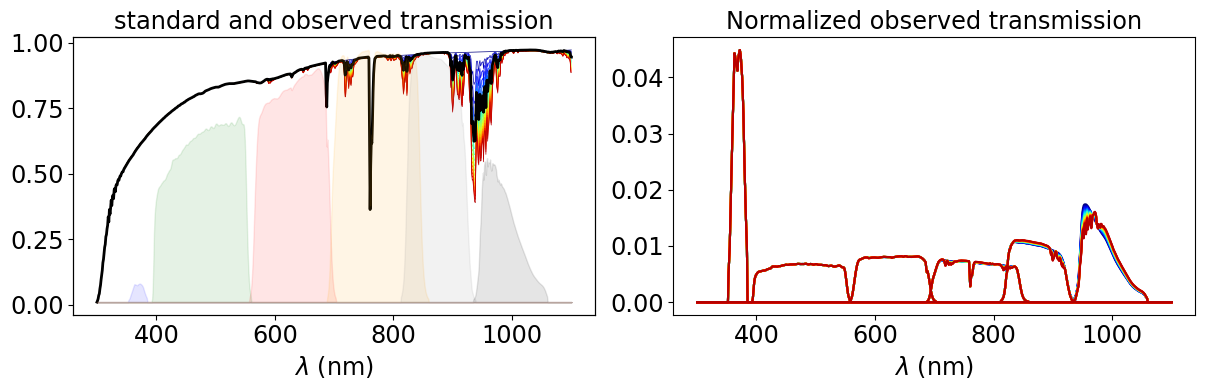

In [19]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(12,4))

# Figure 1
axs=fig.add_subplot(1,2,1)
for index,pwv in enumerate(all_pwv):
  
    atm = pc.coll_atm_nonstd[index]
    
    label = f"pwv={pwv:.1f}" 
    axs.plot(pc.WL,atm,color=all_colors[index],label=label,lw=0.5)
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



# Figure 2
axs=fig.add_subplot(1,2,2)

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,pwv in enumerate(all_pwv):
    
    
    label = f"pwv={pwv:.1f}"
    
    for ifilt,f in enumerate(filter_tagnames):
        
        the_x=pc.WL
        the_y=pc.coll_phiArray_nonstd[idx_pwv][ifilt,:]
       
        
        if ifilt==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  


plt.tight_layout()
plt.show()



## SED

The atlas is grouped into different “blocks” (A, B, C, D, M, and S), corresponding to the physical distinctions of their underlying model atmospheres. It consists of 1434 files, each of which represents a metal-line blanketed flux spectrum for a theoretical stellar model atmosphere. Data files are named “bk_mnnnn.fits”, where m is the block code and nnnn the sequence number.

Physical fluxes of the spectra are given in FLAM surface flux units, i.e.  ergs cm−2 s−1A−1. These flux units differ from those in the Kurucz CD-ROM by a factor of  3.336x10−19∗λ2/4π; i.e. are converted from ergs cm−2 s−1Hz−1 steradian−1 to ergs cm−2 s−1 A−1.  To convert to observed flux at Earth, multiply by a factor of (R/D)2 where R is the stellar radius, and D is the distance to Earth.

In [20]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

In [21]:
seddir = os.path.join(fdir, 'pysynphot', 'bkmodels')

In [22]:
list_of_files = os.listdir(seddir)

In [23]:
spectral_files = []
for filename in list_of_files:
    if ".fits" in filename:
        spectral_files.append(filename)

In [24]:
df = pd.DataFrame(columns=["index","letter","numstr","num","filename"])
for index,file in enumerate(spectral_files):
    letter = re.findall("^bk_(.*)[0-9][0-9][0-9][0-9][.]fits$",file )[0]
    number_str = re.findall("^bk_.*([0-9][0-9][0-9][0-9])[.]fits$",file )[0]
    number = int(number_str)
    df.loc[index] = [index,letter,number_str,number,file]
   

In [25]:
categories = df["letter"].unique()
categories

array(['c', 'b', 'a', 'd', 'm', 's'], dtype=object)

In [26]:
df

,index,letter,numstr,num,filename
0,0,c,0176,176,bk_c0176.fits
1,1,c,0526,526,bk_c0526.fits
2,2,b,0176,176,bk_b0176.fits
3,3,a,0190,190,bk_a0190.fits
4,4,b,0033,33,bk_b0033.fits
...,...,...,...,...,...
1428,1428,d,0060,60,bk_d0060.fits
1429,1429,c,0362,362,bk_c0362.fits
1430,1430,b,0227,227,bk_b0227.fits
1431,1431,c,0227,227,bk_c0227.fits


In [27]:
df_a = df[df.letter == "a"]
df_b = df[df.letter == "b"]
df_c = df[df.letter == "c"]
df_d = df[df.letter == "d"]
df_m = df[df.letter == "m"]
df_s = df[df.letter == "s"]
df_a.reset_index(drop=True,inplace=True)
df_b.reset_index(drop=True,inplace=True)
df_c.reset_index(drop=True,inplace=True)
df_d.reset_index(drop=True,inplace=True)
df_m.reset_index(drop=True,inplace=True)
df_s.reset_index(drop=True,inplace=True)
all_df = [df_a,df_b,df_c,df_d,df_m,df_s]

In [28]:
cat_cmap = ["Purples","Blues","Greens","Oranges","Reds","Greys"]

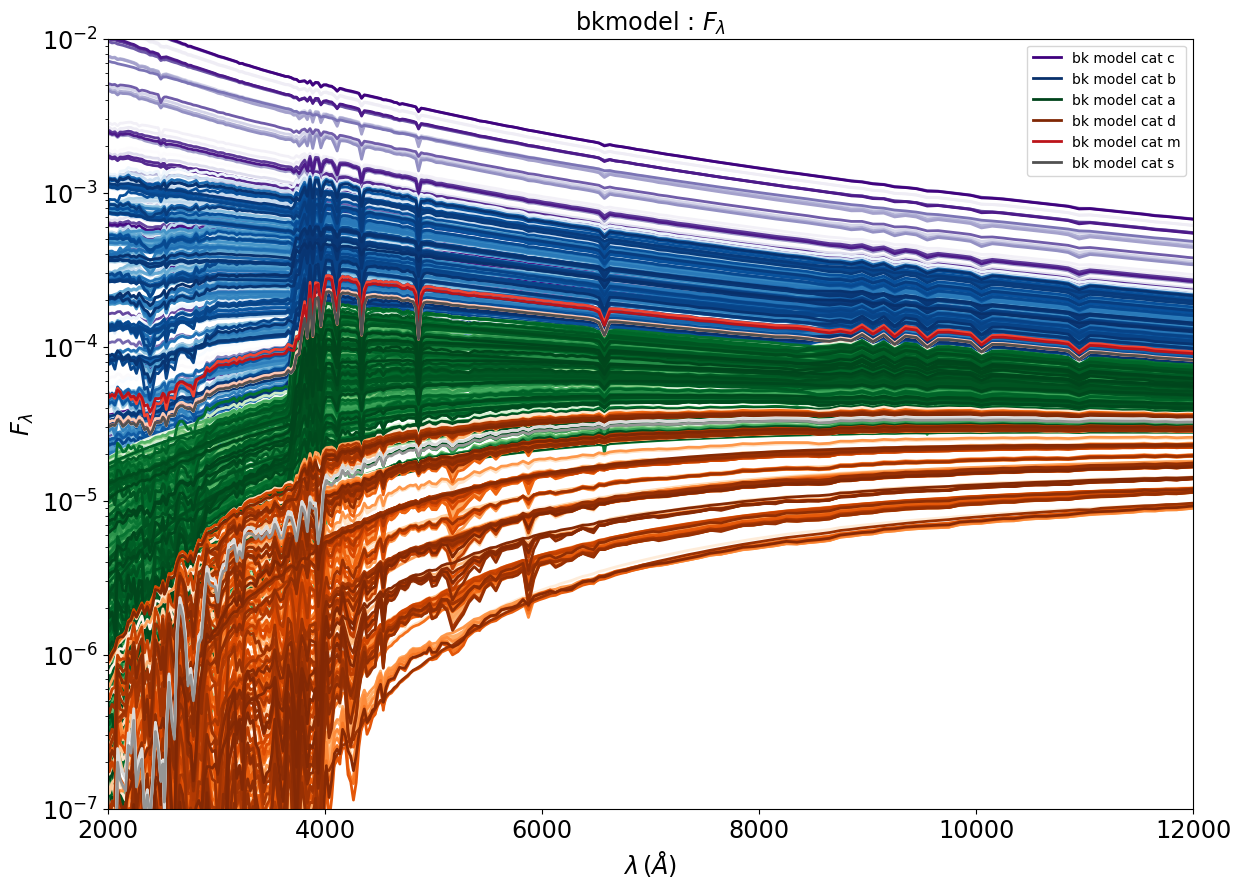

In [29]:
Ncat = len(categories)

fig,ax = plt.subplots(1,1,figsize=(14,10))
all_df_colors = []

for index in range(Ncat) :
    the_df = all_df[index]
    cmapname = cat_cmap[index] 
    cat = categories[index]
    N = len(the_df)
    the_cmap = plt.get_cmap(cmapname)
    cNorm = mpl.colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmapname)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    all_df_colors.append( all_colors)
   
    for idx in range(N):
        row = the_df.loc[idx]
        filename = row["filename"]
        
        fullfilename = os.path.join(seddir,filename)
        
        hdul = fits.open(fullfilename)
        df_sed = pd.DataFrame(hdul[1].data)
        #selection = (df_sed["WAVELENGTH"] > 2000.) & (df_sed["WAVELENGTH"] < 15000.).values
        # avoid Big-endian buffer not supported on little-endian compiler
        #cut = [x.byteswap().newbyteorder() for x in selection]   
        #df_sed = df_sed.loc[cut]

        if idx == N-1:
            label = f"bk model cat {cat}"
            ax.plot( df_sed.WAVELENGTH,df_sed.FLUX,c=all_colors[idx],label=label,lw=2)
        else:
            ax.plot( df_sed.WAVELENGTH,df_sed.FLUX,c=all_colors[idx],lw=2)
            
    
ax.set_xlim(2000.,12000.)
ax.set_ylim(1e-7,1e-2)
ax.set_yscale("log")
ax.set_title("bkmodel : $F_\lambda$")
ax.set_xlabel("$\lambda \, (\\AA) $")
ax.set_ylabel("$F_\lambda$")
ax.legend(loc="upper right")
    


## Convert SED in rubinsim format

In [30]:
all_sed = []
all_df_colors = []

zmag = 20.0

for index in range(Ncat) :
    the_df = all_df[index]
    cmapname = cat_cmap[index] 
    cat = categories[index]
    N = len(the_df)
    the_cmap = plt.get_cmap(cmapname)
    cNorm = mpl.colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmapname)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    all_df_colors.append(all_colors)
    all_sed_cat = []
    
    for idx in range(N):
        row = the_df.loc[idx]
        filename = row["filename"]
        name = filename.split(".")[0]
        fullfilename = os.path.join(seddir,filename)
        
        hdul = fits.open(fullfilename)
        df_sed = pd.DataFrame(hdul[1].data)
       
        wl= df_sed.WAVELENGTH.values
        flux = df_sed.FLUX.values
        the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=name)
        flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
        the_sed.multiply_flux_norm(flux_norm)
        
        all_sed_cat.append(the_sed)
    all_sed.append(all_sed_cat)    

In [31]:
len(all_sed[0])

278

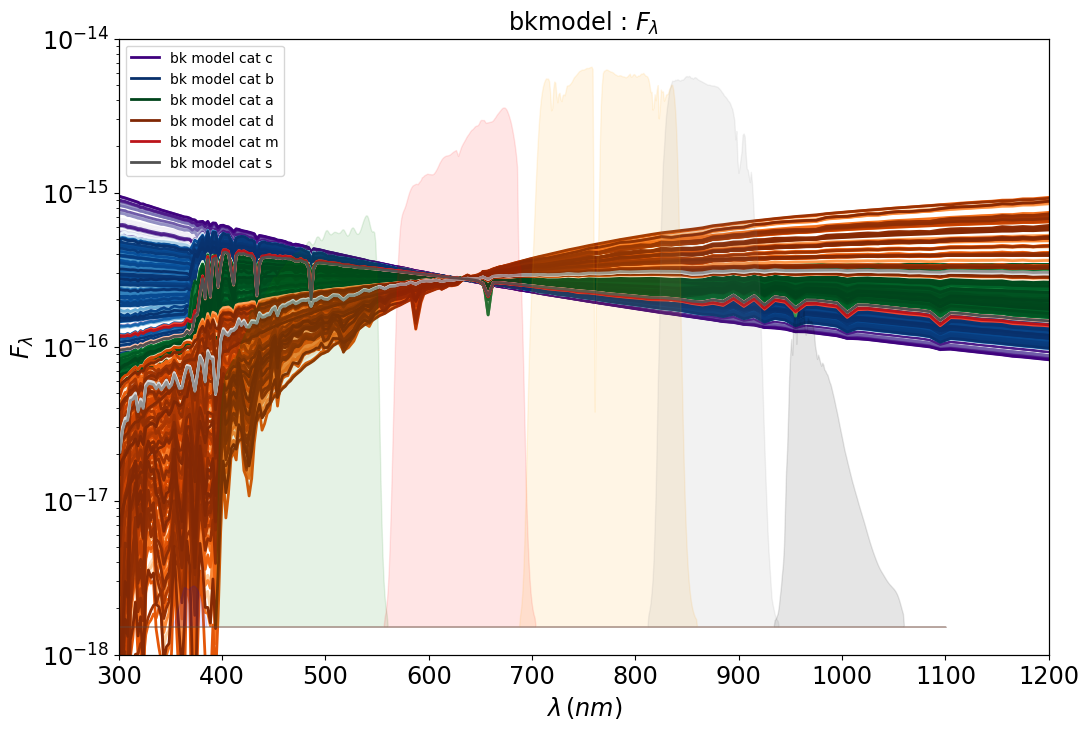

In [32]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

for index in range(Ncat) :
    all_sed_cat = all_sed[index]
    cat = categories[index]
    N = len(all_sed_cat)
    all_colors =  all_df_colors[index]
   
   
    for idx in range(N):
        the_sed = all_sed_cat[idx] 
        if idx == N-1:
            label = f"bk model cat {cat}"
            ax.plot( the_sed.wavelen,the_sed.flambda,c=all_colors[idx],label=label,lw=2)
        else:
            ax.plot(the_sed.wavelen,the_sed.flambda,c=all_colors[idx],lw=2)
                
ax.set_xlim(300.,1200.)
ax.set_ylim(1e-18,1e-14)
ax.set_yscale("log")
ax.set_title("bkmodel : $F_\lambda$")
ax.set_xlabel("$\lambda \, (nm) $")
ax.set_ylabel("$F_\lambda$")
ax.legend(loc="upper left")

ax2 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


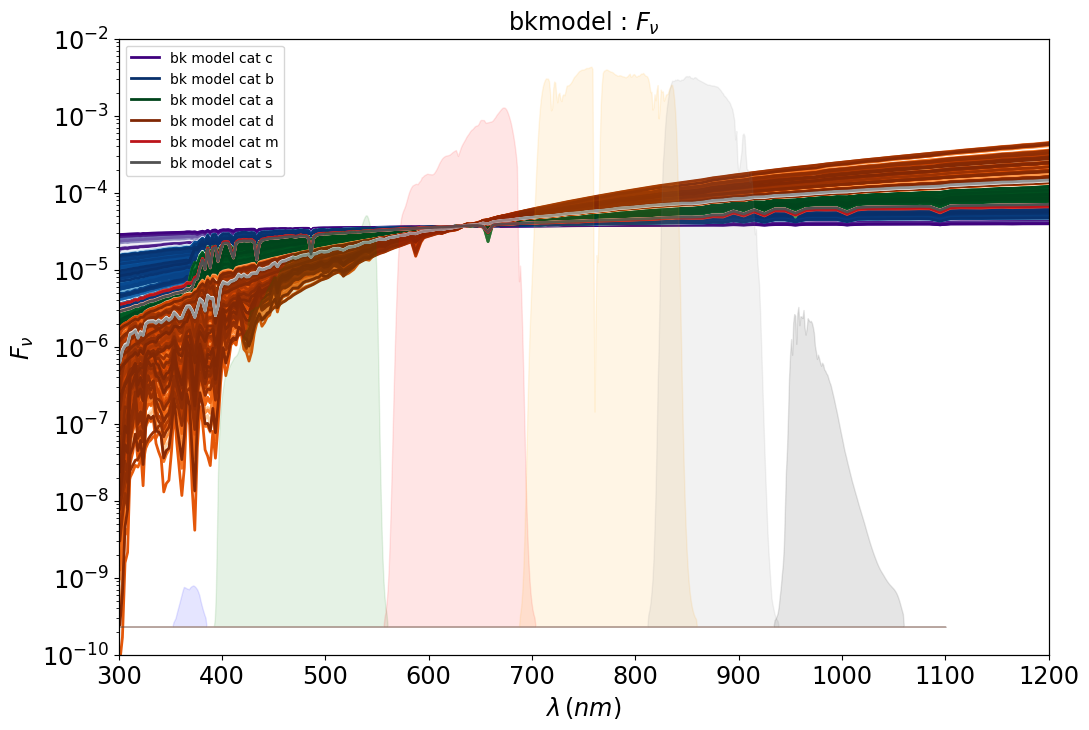

In [33]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

for index in range(Ncat) :
    all_sed_cat = all_sed[index]
    cat = categories[index]
    N = len(all_sed_cat)
    all_colors =  all_df_colors[index]
   
   
    for idx in range(N):
        the_sed = all_sed_cat[idx] 
        if idx == N-1:
            label = f"bk model cat {cat}"
            ax.plot( the_sed.wavelen,the_sed.fnu,c=all_colors[idx],label=label,lw=2)
        else:
            ax.plot(the_sed.wavelen,the_sed.fnu,c=all_colors[idx],lw=2)
                
ax.set_xlim(300.,1200.)
ax.set_ylim(1e-10,1e-2)
ax.set_yscale("log")
ax.set_title("bkmodel : $F_\\nu$")
ax.set_xlabel("$\lambda \, (nm) $")
ax.set_ylabel("$F_\\nu$")
ax.legend(loc="upper left")

ax2 = ax.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


## Generate dataframe with magnitudes

In [43]:
photoparams = set_photometric_parameters(30, 1 , readnoise=None)
# container for all cat
all_dfout = [] 

for index in range(Ncat) :  
    all_sed_cat = all_sed[index]
    the_df = all_df[index]
    
    cat = categories[index]
    N = len(all_sed_cat)
 
   
    df_out = pd.DataFrame(columns = ["index","filename","spectype",
                                 "magu","magg","magr","magi","magz","magy",
                                "aduu","adug","adur","adui","aduz","aduy"])

    # loop on SED
    for idx in range(N):
        the_sed = all_sed_cat[idx] 
        
        row = the_df.loc[idx]
        filename = row["filename"]
        num = row["index"]
        name = the_sed.name
        
        mags_std = {}
        adcs_stdmag = {}
        # compute mags by loop on filters
        for idx2,f in enumerate(filter_tagnames) :
            mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
            adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
            
        df_out.loc[idx] = [ num,filename, name ,
                              mags_std["u"],mags_std["g"],mags_std["r"],mags_std["i"],mags_std["z"],mags_std["y"],
                             adcs_stdmag["u"],adcs_stdmag["g"],adcs_stdmag["r"],adcs_stdmag["i"],adcs_stdmag["z"],adcs_stdmag["y"]]

    # compute colors over all SED
    df_out["magG_R"] = df_out["magg"] - df_out["magr"]
    df_out["magZ_Y"] = df_out["magz"] - df_out["magy"]
    df_out["aduG_R"] = df_out["adug"] - df_out["adur"]
    df_out["aduZ_Y"] = df_out["aduz"] - df_out["aduy"]

    all_dfout.append(df_out)
                                

In [44]:
df_out = all_dfout[0].head() 

In [46]:
df_out["index0"] = df_out.index

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_70286/2070867876.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["index0"] = df_out.index


In [47]:
df_out

,index,filename,spectype,magu,magg,magr,magi,magz,magy,aduu,adug,adur,adui,aduz,aduy,magG_R,magZ_Y,aduG_R,aduZ_Y,index0
0,3,bk_a0190.fits,bk_a0190,21.664614,20.322759,20.0,19.800884,19.606361,19.421790,-5.539966,-11.067485,-11.167394,-11.447856,-11.067939,-10.076595,0.322759,0.184571,0.099909,-0.991344,0
1,9,bk_a0256.fits,bk_a0256,20.507854,20.154366,20.0,19.913582,19.856679,19.799268,-6.696727,-11.235878,-11.167394,-11.335159,-10.817621,-9.699117,0.154366,0.057411,-0.068485,-1.118504,1
2,17,bk_a0082.fits,bk_a0082,22.155358,20.687834,20.0,19.597663,19.374908,19.143569,-5.049223,-10.702411,-11.167394,-11.651077,-11.299392,-10.354817,0.687834,0.231339,0.464983,-0.944575,2
3,18,bk_a0128.fits,bk_a0128,22.858526,21.044072,20.0,19.435036,19.136091,18.841309,-4.346055,-10.346173,-11.167394,-11.813705,-11.538208,-10.657076,1.044072,0.294782,0.821221,-0.881132,3
4,20,bk_a0201.fits,bk_a0201,21.592965,20.296242,20.0,19.817730,19.669703,19.493691,-5.611616,-11.094002,-11.167394,-11.431011,-11.004596,-10.004694,0.296242,0.176013,0.073392,-0.999902,4


Text(0, 0.5, 'G-R (adu) (mag)')

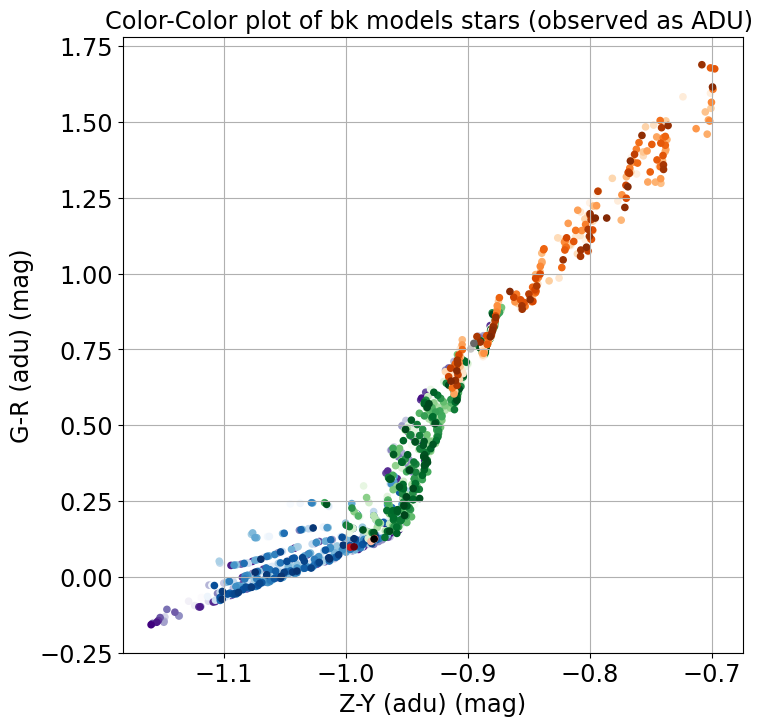

In [48]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

for index in range(Ncat) : 
    df_out = all_dfout[index]
    cat = categories[index]
    N = len(df_out)
    cmap = cat_cmap[index]
    df_out["index0"] = df_out.index
    df_out.plot.scatter(x="aduZ_Y",y="aduG_R",marker="o",c="index0",colormap=cmap,ax=ax,grid=True,colorbar=False)
    

ax.set_title("Color-Color plot of bk models stars (observed as ADU) ")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")

Text(0, 0.5, 'G-R  (mag)')

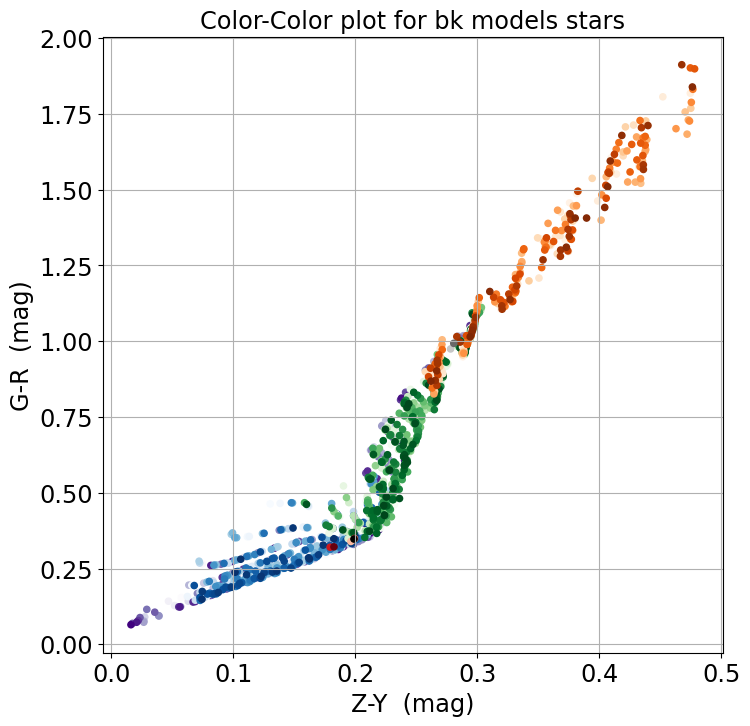

In [50]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

for index in range(Ncat) : 
    df_out = all_dfout[index]
    cat = categories[index]
    N = len(df_out)
    cmap = cat_cmap[index]
    df_out["index0"] = df_out.index
    df_out.plot.scatter(x="magZ_Y",y="magG_R",marker="o",c="index0",colormap=cmap,ax=ax,grid=True,colorbar=False)


ax.set_title("Color-Color plot for bk models stars")
ax.set_xlabel("Z-Y  (mag)")
ax.set_ylabel("G-R  (mag)")

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
df_out.plot.scatter(x="index",y="magG_R",ax=ax1,grid=True,c="b")
df_out.plot.scatter(x="index",y="magZ_Y",ax=ax2,grid=True,c="r")

labels1 = [item.get_text() for item in ax1.get_xticklabels()]
labels2 = [item.get_text() for item in ax2.get_xticklabels()]

ax1.locator_params(axis='x', nbins=2*len(labels1)) 
ax2.locator_params(axis='x', nbins=2*len(labels2)) 

labels1 = [item.get_text() for item in ax1.get_xticklabels()]
labels2 = [item.get_text() for item in ax2.get_xticklabels()]

Nlabels1 = len(labels1)
for ilab in range(1,Nlabels1-1):
    the_label = int(labels1[ilab])
    #print(ilab,the_label,df_out.loc[the_label,"spectype"])
    labels1[ilab] = df_out.loc[the_label,"spectype"]
ax1.set_xticklabels(labels1,rotation=90)
ax1.set_xlabel(None)


Nlabels2 = len(labels2)
for ilab in range(1,Nlabels2-1):
    the_label = int(labels2[ilab])
    #print(ilab,the_label,df_out.loc[the_label,"spectype"])
    labels2[ilab] = df_out.loc[the_label,"spectype"]
ax2.set_xticklabels(labels2,rotation=90)
ax2.set_xlabel(None)

ax1.set_title("Pickles stars colors")

plt.tight_layout()